In [276]:
# Necessary imports
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold
import numpy as np

from sklearn import tree
import matplotlib.pyplot as plt

In [277]:
def load_data():
    # Define the column names
    column_names = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'class']

    # Load the data and add column names
    data = pd.read_csv('data/nursery.data', delimiter=',', names=column_names)

    return data

In [278]:
data = load_data()

# Print the shape of the data
print("Data Shape: ", data.shape)

# Print the first 10 rows
print(data.head(10).to_string(), "\n")

Data Shape:  (12960, 9)
  parents has_nurs      form children     housing     finance         social       health       class
0   usual   proper  complete        1  convenient  convenient        nonprob  recommended   recommend
1   usual   proper  complete        1  convenient  convenient        nonprob     priority    priority
2   usual   proper  complete        1  convenient  convenient        nonprob    not_recom   not_recom
3   usual   proper  complete        1  convenient  convenient  slightly_prob  recommended   recommend
4   usual   proper  complete        1  convenient  convenient  slightly_prob     priority    priority
5   usual   proper  complete        1  convenient  convenient  slightly_prob    not_recom   not_recom
6   usual   proper  complete        1  convenient  convenient    problematic  recommended    priority
7   usual   proper  complete        1  convenient  convenient    problematic     priority    priority
8   usual   proper  complete        1  convenient  conveni

In [279]:
# Get information about the data
print(data.describe().to_string(), "\n")

# Check if there are missing values
print(data.isnull().sum())

# Check the unique values in the class column
print(data['class'].value_counts())

       parents has_nurs      form children     housing     finance   social       health      class
count    12960    12960     12960    12960       12960       12960    12960        12960      12960
unique       3        5         4        4           3           2        3            3          5
top      usual   proper  complete        1  convenient  convenient  nonprob  recommended  not_recom
freq      4320     2592      3240     3240        4320        6480     4320         4320       4320 

parents     0
has_nurs    0
form        0
children    0
housing     0
finance     0
social      0
health      0
class       0
dtype: int64
class
not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        2
Name: count, dtype: int64


In [280]:
# # Assuming your DataFrame is named df
# data['EMPLOY'] = data['parents'] + '_' + data['has_nurs']
# data['STRUCT_FINAN'] = data['form'] + '_' + data['children'].astype(str) + '_' + data['housing'] + '_' + data['finance']
# data['SOC_HEALTH'] = data['social'] + '_' + data['health']

# # Get information about the data
# print(data.describe().to_string(), "\n")

# # Check if there are missing values
# print(data.isnull().sum())

# # Check the unique values in the class column
# print(data['class'].value_counts())

In [293]:
def split_data(data, combine):
    # Separate the features and target variable before encoding
    X = data.drop('class', axis=1)
    y = data['class']

    # Combine 'recommend' and 'very_recom' into 'recommend_or_very_recom'
    if combine:
        y = y.replace({
            'recommend': 'recommend_or_very_recom',
            'very_recom': 'recommend_or_very_recom'
        })

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, random_state=13)

    return X_train, X_test, y_train, y_test, X, y

In [282]:
def training_with_DecisionTree(X_train, y_train, criteria):
    # Train the model with criteria
    model = DecisionTreeClassifier(criterion=criteria, random_state=13, max_depth=3, min_samples_leaf=1, class_weight={'not_recom': 1, 'priority': 1, 'recommend_or_very_recom': 1, 'spec_prior': 1})

    # Fit the model
    model.fit(X_train, y_train)

    return model

In [283]:
from sklearn.ensemble import RandomForestClassifier

def training_with_RandomForest(X_train, y_train):
    model = RandomForestClassifier(n_estimators=300, random_state=13, max_depth=3, min_samples_leaf=1, class_weight='balanced')

    # Fit the model
    model.fit(X_train, y_train)

    return model

In [284]:
from sklearn.ensemble import GradientBoostingClassifier

def training_with_GradientBoosting(X_train, y_train):
    model = GradientBoostingClassifier(n_estimators=300, random_state=13, max_depth=3, min_samples_leaf=1)

    # Fit the model
    model.fit(X_train, y_train)

    return model

In [285]:
def training_with_XGBoost(X_train, y_train):#, X_val, y_val):
    model = xgb.XGBClassifier(n_estimators=100)

    # model = xgb.XGBClassifier(n_estimators=1000)  # Set a high number for n_estimators
    # model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_val, y_val)])

    # Fit the model
    model.fit(X_train, y_train)

    return model

In [286]:
def predict(model, X_test):
    # Predict the target variable
    y_pred = model.predict(X_test)

    return y_pred

In [287]:
def evaluate(y_test, y_pred):
    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, zero_division=0)

    f1 = f1_score(y_test, y_pred, average='weighted')

    return confusion, classification_rep, f1

In [288]:
# Split the data
X_train, X_test, y_train, y_test, X, y = split_data(data)

# Get information about the data
print(X.describe().to_string(), "\n")
print(X.head(5).to_string(), "\n")
print(y.value_counts(), "\n")

       parents has_nurs      form children     housing     finance   social       health
count    12960    12960     12960    12960       12960       12960    12960        12960
unique       3        5         4        4           3           2        3            3
top      usual   proper  complete        1  convenient  convenient  nonprob  recommended
freq      4320     2592      3240     3240        4320        6480     4320         4320 

  parents has_nurs      form children     housing     finance         social       health
0   usual   proper  complete        1  convenient  convenient        nonprob  recommended
1   usual   proper  complete        1  convenient  convenient        nonprob     priority
2   usual   proper  complete        1  convenient  convenient        nonprob    not_recom
3   usual   proper  complete        1  convenient  convenient  slightly_prob  recommended
4   usual   proper  complete        1  convenient  convenient  slightly_prob     priority 

class
not_r

In [289]:
# Create LabelEncoder object
le = LabelEncoder()

# LabelEncoder on each column of X_train and X_test
X_train_numeric = X_train.apply(le.fit_transform)
X_test_numeric = X_test.apply(le.fit_transform)

# Prints
print(X_train.head(3).to_string(), "\n")
print(X_train_numeric.head(3).to_string(), "\n")

          parents  has_nurs        form children     housing     finance         social       health
6932  pretentious  critical    complete        1   less_conv  convenient        nonprob    not_recom
555         usual    proper  incomplete        3  convenient      inconv    problematic  recommended
2451        usual  improper      foster        2   less_conv  convenient  slightly_prob  recommended 

      parents  has_nurs  form  children  housing  finance  social  health
6932        1         0     0         0        2        0       0       0
555         2         3     3         2        0        1       1       2
2451        2         1     2         1        2        0       2       2 



In [290]:
# from sklearn.model_selection import GridSearchCV

# def tune_random_forest(X_train, y_train):
#     # Define the parameter grid
#     param_grid = {
#         'n_estimators': [200, 300, 400],
#     }

#     # Create a RandomForestClassifier object
#     model = RandomForestClassifier(random_state=13, class_weight='balanced')

#     # Create a GridSearchCV object
#     grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted')

#     # Fit GridSearchCV
#     grid_search.fit(X_train, y_train)

#     # Get the best parameters
#     best_params = grid_search.best_params_

#     return best_params

In [291]:
# from sklearn.model_selection import GridSearchCV
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import BorderlineSMOTE
# from sklearn.tree import DecisionTreeClassifier

# # Create a pipeline
# pipe = Pipeline([('smote', BorderlineSMOTE()), 
#                  ('classifier', DecisionTreeClassifier())])

# # Create the grid parameter
# grid = {'smote__k_neighbors': [3, 5, 7, 9, 11],
#         'smote__m_neighbors': [5, 10, 15, 20],
#         'smote__kind': ['borderline-1', 'borderline-2', 'regular']}

# # Create the grid, with "pipe" as the estimator
# gridsearch = GridSearchCV(estimator=pipe, 
#                           param_grid=grid, 
#                           scoring='f1_weighted', 
#                           cv=5)

# # Fit using grid search
# gridsearch.fit(X_train_numeric, y_train)

# # Best accuracy
# print('Best F1 Score: ', gridsearch.best_score_)

# # Best params
# print('\nBest parameters:\n', gridsearch.best_params_)

In [292]:
# from imblearn.over_sampling import SMOTE

# # Now you can apply SMOTE
# smote = SMOTE()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_numeric, y_train)

# from imblearn.over_sampling import BorderlineSMOTE

# # Create a BorderlineSMOTE object
# smote = BorderlineSMOTE(k_neighbors=3, m_neighbors=10, kind='borderline-1')

# # Resample the training data
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_numeric, y_train)

# # Tune the model
# best_params = tune_random_forest(X_train_resampled, y_train_resampled)
# print("Best parameters: ", best_params)

# Fit and transform the target variable
y_train_encoded = le.fit_transform(y_train)

print(y_train_encoded)

# Train the model
model = training_with_XGBoost(X_train_numeric, y_train_encoded)

# Transform y_test to the encoded form
y_test_encoded = le.transform(y_test)

# Prediction and evaluation
y_pred = predict(model, X_test_numeric)
confusion, classification, f1 = evaluate(y_test_encoded, y_pred)

# Prints
print("Confusion Matrix: \n", confusion)
print("Classification Report: \n", classification)
print("F1 Score: ", f1)

# Define the stratified k-fold cross-validation
stratifiedKF = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

# Perform cross-validation
scores = cross_val_score(model, X_train_numeric, y_train_encoded, cv=stratifiedKF, scoring='f1_weighted')

# Print the cross-validation scores for each fold and average
print("Cross-validation scores:", scores)
print("Average cross-validation score:", np.mean(scores))

[0 1 1 ... 3 0 0]
Confusion Matrix: 
 [[1044    0    0    0    0]
 [   0 1087    0    0    0]
 [   0    0    0    0    1]
 [   0    0    0 1018    0]
 [   0    0    0    0   90]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       1.00      1.00      1.00      1087
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00      1018
           4       0.99      1.00      0.99        90

    accuracy                           1.00      3240
   macro avg       0.80      0.80      0.80      3240
weighted avg       1.00      1.00      1.00      3240

F1 Score:  0.9995378896391788


d:\User\Documents\MasterProjects\KDDM-PosterWorkshop\.conda\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.99897123 0.99948309 1.         1.                nan]
Average cross-validation score: nan


d:\User\Documents\MasterProjects\KDDM-PosterWorkshop\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\User\Documents\MasterProjects\KDDM-PosterWorkshop\.conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\User\Documents\MasterProjects\KDDM-PosterWorkshop\.conda\Lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "d:\User\Documents\MasterProjects\KDDM-PosterWorkshop\.cond

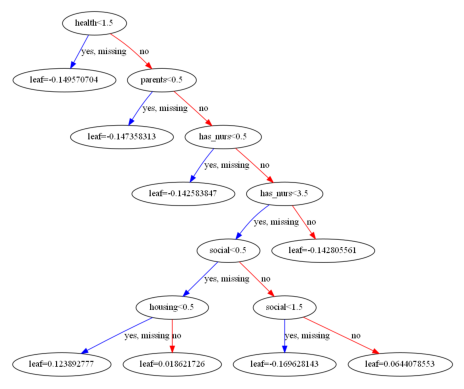

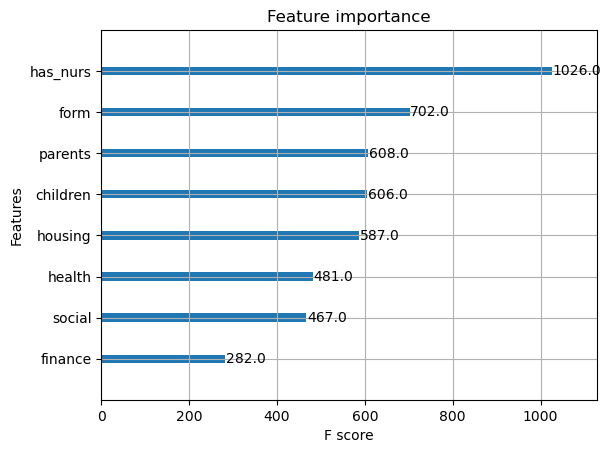

Number of trees: 200
Sizes of trees: [3, 47, 25, 41, 3, 49, 25, 43, 3, 49, 15, 43, 3, 51, 15, 43, 3, 55, 15, 47, 3, 57, 15, 43, 3, 57, 15, 43, 3, 55, 15, 65, 3, 57, 15, 65, 3, 61, 21, 65, 3, 57, 15, 63, 3, 63, 21, 61, 3, 65, 21, 63, 3, 59, 25, 55, 3, 65, 15, 63, 3, 59, 15, 89, 3, 59, 33, 101, 3, 63, 35, 97, 3, 63, 25, 115, 3, 59, 19, 101, 3, 61, 31, 107, 3, 107, 19, 101, 3, 61, 29, 107, 3, 109, 21, 113, 3, 109, 19, 111, 3, 101, 19, 109, 3, 109, 19, 111, 3, 97, 31, 93, 3, 113, 19, 113, 3, 87, 47, 103, 3, 101, 33, 97, 3, 107, 41, 107, 3, 93, 29, 113, 3, 99, 27, 103, 3, 87, 31, 105, 3, 91, 29, 89, 3, 101, 31, 105, 3, 95, 27, 83, 3, 105, 63, 103, 3, 83, 39, 101, 3, 87, 31, 87, 3, 109, 59, 101, 3, 79, 27, 93, 3, 97, 29, 73, 3, 85, 55, 95, 3, 77, 41, 81, 3, 83, 39, 95, 3, 81, 33, 87, 3, 77, 33, 91, 3, 77, 47, 69]


In [240]:
import xgboost as xgb

xgb.plot_tree(model, num_trees=62)
plt.show()

xgb.plot_importance(model)
plt.show()

num_trees = len(model.get_booster().get_dump())
print(f'Number of trees: {num_trees}')

trees = model.get_booster().get_dump()
tree_sizes = [tree.count('\n') for tree in trees]
print(f'Sizes of trees: {tree_sizes}')

# trees = model.get_booster().get_dump()
# tree_sizes = [(i, tree.count('\n')) for i, tree in enumerate(trees) if tree.count('\n') <= 15 and tree.count('\n') > 3]
# print(f'Sizes of trees: {tree_sizes}')

# # Get the feature names
# feature_names = X_train.columns.tolist()
# class_names = y_train.unique().tolist()

# fig, ax = plt.subplots(figsize=(15, 7.5))  # Adjust size as needed
# tree.plot_tree(model, filled=True, rounded=True, feature_names=feature_names, class_names=class_names, ax=ax)
# plt.show()

# from sklearn.tree import export_graphviz

# export_graphviz(clf, out_file='tree.dot', 
#                 feature_names=feature_names,  # replace with your real feature names
#                 class_names=class_names,  # replace with your real class names
#                 filled=True)

# # Convert to PNG using system command (requires Graphviz)
# !dot -Tpng tree.dot -o tree.png

In [29]:
import seaborn as sns
import pandas as pd

# Sample 1000 rows from X_encoded and y
sampled_X = X_encoded.sample(1000)
sampled_y = y.loc[sampled_X.index]

# Convert boolean columns in sampled_X to integers
sampled_X = sampled_X.astype(int)

# Combine sampled_X and sampled_y into a single DataFrame
data = pd.concat([sampled_X, sampled_y], axis=1)

# Create the boxplot
sns.boxplot(x=sampled_X.columns[0], y=sampled_y.name, data=data)
plt.show()

NameError: name 'X_encoded' is not defined

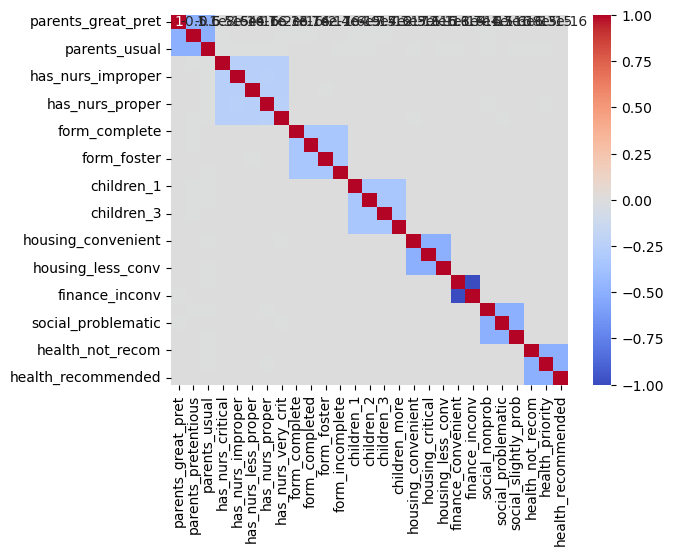

In [128]:
import seaborn as sns

# Assuming X_encoded is your data
corr = X_encoded.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()